![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

In [1]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

# Creating a catalog - From waveforms to events

This model shows how to use [SeisBench](https://github.com/seisbench/seisbench) and the [GaMMA associator](https://github.com/wayneweiqiang/GaMMA) to create an earthquake catalog from raw waveforms. First, we will prepare raw waveforms and station file. Second, we will use different model in SeisBench to obtain phase arrival picks. Third, we use the GaMMA associator to associate the picks to events. Finally, We will visualize the results.

In [2]:
import os
import pickle
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from gamma.utils import association
import seisbench.models as sbm

sns.set(font_scale=1.2)
sns.set_style("ticks")

## Configuration

The following codeblock contains all configurations. The first block configures the local coordinate projection. In this case, we use a transverse mercator projection for Chile, as we will be using data from northern Chile. The second, third and fourth blocks configures the gamma associator. Please see it's documentation for details.

In [3]:
# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(9155)  # SIRGAS-Chile 2016 / UTM zone 19S
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (250, 600)
config["y(km)"] = (7200, 8000)
config["z(km)"] = (0, 150)
config["vel"] = {"p": 7.0, "s": 7.0 / 1.75}  # We assume rather high velocities as we expect deeper events
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

## Obtaining the data

In this example, we want to use those waveforms which are existed between starttime and endtime. To extract waveforms belonging to specific interval, 'start_year_analysis', 'start_day_analysis', 'end_year_analysis', 'end_day_analysis' are used.
Note: To get the stations, "client.get_stations" function has been used. 

We use the first day of Jan. 2012.

In [4]:
start_year_analysis = 2012
start_day_analysis = 1
end_year_analysis = 2012
end_day_analysis = 1

from data_preprocessing import Data_Preprocessing

obj = Data_Preprocessing (start_year_analysis, start_day_analysis,
                    end_year_analysis, end_day_analysis)

stream = obj.get_waveforms_chile()
client = Client("GFZ")
inv = client.get_stations(network="CX", station="*", location="*", channel="HH?", starttime=UTCDateTime("2014/05/01 00:00:00"), endtime=UTCDateTime("2014/05/01 00:00:00")+12*60)

print (len(stream))


51


In [5]:
inv

Inventory created at 2022-07-04T11:43:23.019258Z
	Sending institution: SeisComP (GFZ)
	Contains:
		Networks (1):
			CX
		Stations (20):
			CX.HMBCX (IPOC Station Humberstone, Chile)
			CX.MNMCX (IPOC Station Minimi, Chile)
			CX.PATCX (IPOC Station Patache, Chile)
			CX.PB01 (IPOC Station Huatacondo, Chile)
			CX.PB02 (IPOC Station Salar Grande, Chile)
			CX.PB03 (IPOC Station El Tigre, Chile)
			CX.PB04 (IPOC Station Mantos de la Luna, Chile)
			CX.PB05 (IPOC Station Michilla, Chile)
			CX.PB06 (IPOC Station Pedro de Valdivia, Chile)
			CX.PB07 (IPOC Station Cerro Tatas, Chile)
			CX.PB08 (IPOC Station Macaya, Chile)
			CX.PB09 (IPOC Station Quillagua, Chile)
			CX.PB10 (IPOC Station Juan Lopez, Chile)
			CX.PB11 (IPOC Station Quebrada Aricilda, Chile)
			CX.PB12 (IPOC Station Cerro Caramaca near Arica, Chile)
			CX.PB13 (IPOC Station Cerro Chaquipina, Chile)
			CX.PB14 (IPOC Station European Southern Observatory Cerro Paranal, Chile)
			CX.PB15 (IPOC Station Sierra Gorda, Chile)
			C

## Phase Picking

For this example, we use EQTransformer trained on the INSTANCE dataset from Italy. However, in principal any picker could be used for obtaining the picks with only minimal changes.

**Warning:** This will take some time and requires sufficient main memory. If you are short on memory, reduce the study in the cell before.

**Note:** We automatically check if CUDA is available and run the model on CUDA in this case. Alternatively, the model runs on CPU.

In [6]:
picker = sbm.PhaseNet.from_pretrained("instance")

if torch.cuda.is_available():
    picker.cuda()

# We tuned the thresholds a bit - Feel free to play around with these values
#picks, _ = picker.classify(stream, batch_size=256, P_threshold=0.7, S_threshold=0.7, parallelism=1)
picks = picker.classify(stream, batch_size=256, P_threshold=0.5, S_threshold=0.5, parallelism=1)

Counter([p.phase for p in picks])  # Output number of P and S picks

Counter({'S': 1348, 'P': 1471})

We now convert the picks and station metadata into pandas dataframes in the format required for the GaMMA associator.

In [7]:
pick_df = []
for p in picks:
    pick_df.append({
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)

station_df = []
for station in inv[0]:
    station_df.append({
        "id": f"CX.{station.code}.",
        "longitude": station.longitude,
        "latitude": station.latitude,
        "elevation(m)": station.elevation
    })
station_df = pd.DataFrame(station_df)

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["latitude"], x["longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = station_df["elevation(m)"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}

Let's have a look at the picks generated by the model. Note that we retained the probability from the deep learning model. It will be used by the associator later on.

In [8]:
pick_df.sort_values("timestamp")

,id,timestamp,prob,type
0,CX.PB07.,2012-01-01 00:00:14.378394,0.636098,s
1,CX.CAR3.00,2012-01-01 00:05:51.810000,0.559211,s
2,CX.PB11.,2012-01-01 00:06:23.090000,0.776417,s
1312,CX.PB11.,2012-01-01 00:07:51.530000,0.690982,p
3,CX.PB02.,2012-01-01 00:08:12.558394,0.570755,s
...,...,...,...,...
2812,CX.PB03.,2012-01-01 23:58:21.848391,0.571228,s
2815,CX.PB01.,2012-01-01 23:59:27.888393,0.750934,p
2818,CX.PB11.,2012-01-01 23:59:36.500000,0.800446,p
2816,CX.PB14.,2012-01-01 23:59:48.060000,0.688494,s


In [9]:
station_df

,id,longitude,latitude,elevation(m),x(km),y(km),z(km)
0,CX.PB01.,-69.48740,-21.043230,900.0,449.359240,7672.990624,0.900
1,CX.PB02.,-69.89603,-21.319730,1015.0,407.073618,7642.202105,1.015
2,CX.PB03.,-69.75310,-22.048470,1460.0,422.289208,7561.616351,1.460
3,CX.PB04.,-70.14918,-22.333690,1520.0,381.654501,7529.786448,1.520
4,CX.PB05.,-70.20235,-22.852830,1150.0,376.641792,7472.269037,1.150
5,CX.PB06.,-69.57188,-22.705800,1440.0,441.265933,7488.934343,1.440
6,CX.PB07.,-69.88618,-21.726670,1570.0,408.350830,7597.163958,1.570
7,CX.PB08.,-69.15340,-20.141120,3060.0,483.967892,7772.894838,3.060
8,CX.PB09.,-69.24192,-21.796380,1530.0,474.993268,7589.691040,1.530
9,CX.PB10.,-70.55408,-23.513430,250.0,341.330885,7398.783176,0.250


## Association

We now run the phase association. This will take a moment. We convert the output into two dataframes, one for the catalog and one for the assignment of picks to the catalog.

In [10]:
pbar = tqdm(1)
catalogs, assignments = association(pick_df, station_df, config, method=config["method"], pbar=pbar)

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

Process 5 picks: : 0it [00:09, ?it/s] 

## Visualizing the catalog

Let's have a look at the catalog.

In [11]:
catalog.shape

(132, 11)

We can also plot the catalog. Conveniently, we are already in a local transverse mercator projection, so need for further thought in the plotting here.

We use the `scatter` function and encode the depth of the events using color. The plot nicely resolves the intense shallow seismicity in the Iquique area (offshore, Northing arong 7800 km, Easting around 300 km). It also shows the seismicity along the Slap (West-East dipping).

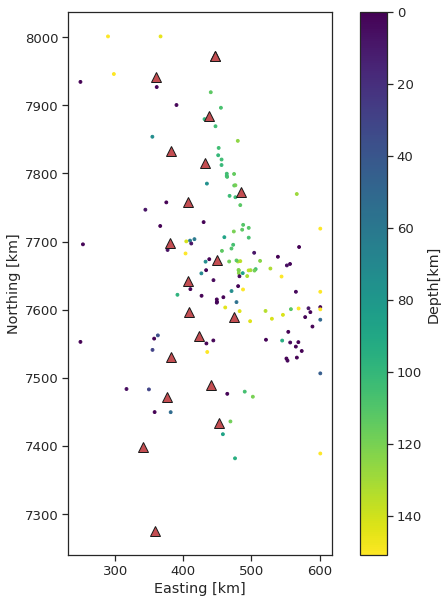

In [12]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

As a last check, we manually inspect some events. The code block below selects a random event and plots the waveforms, together with the P (solid black lines) and S (dashed black lines). The x axis denotes the time, the y axis the distance between station and estimated event location. Therefore, we should see roughly a hyperbolic moveout. Run the cell a few times to see a few example events.

Event information
time            2012-01-01T05:32:28.593
time(s)                    19934.215582
magnitude                           999
sigma_time                     1.189852
sigma_amp                             0
cov_time_amp                          0
prob_gamma                         17.0
event_idx                            34
x(km)                        410.348727
y(km)                       7630.103393
z(km)                          0.474853
Name: 34, dtype: object


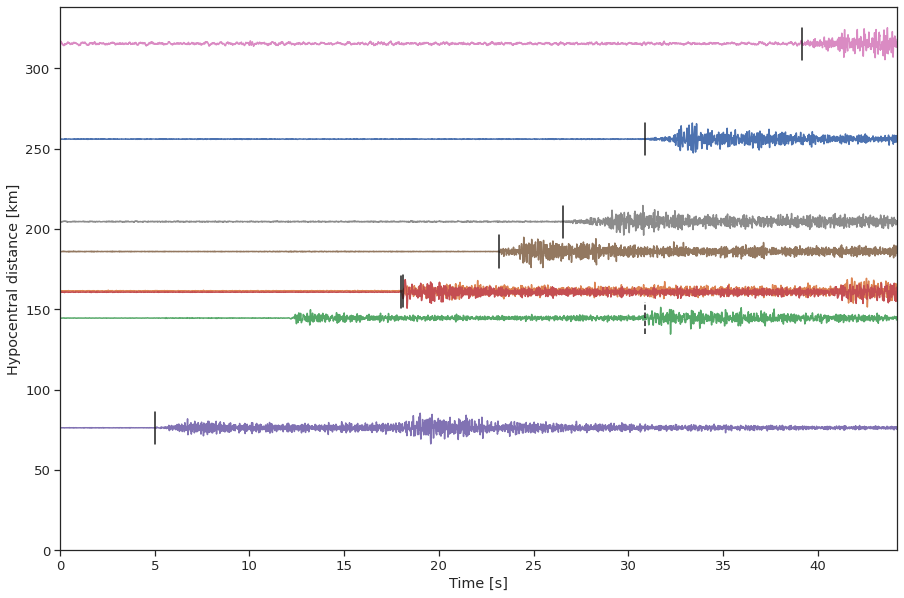

In [14]:
event_idx = np.random.randint(len(catalog))
event_picks = [picks[i] for i in assignments[assignments["event_idx"] == event_idx]["pick_idx"]]
event = catalog.iloc[event_idx]

first, last = min(pick.peak_time for pick in event_picks), max(pick.peak_time for pick in event_picks)

sub = obspy.Stream()

for station in np.unique([pick.trace_id for pick in event_picks]):
    sub.append(stream.select(station=station[3:-1], channel="HHZ")[0])

sub = sub.slice(first - 5, last + 5)

sub = sub.copy()
sub.detrend()
sub.filter("highpass", freq=2)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

for i, trace in enumerate(sub):
    normed = trace.data - np.mean(trace.data)
    normed = normed / np.max(np.abs(normed))
    station_x, station_y = station_dict[trace.id[:-4]]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    ax.plot(trace.times(), 10 * normed + y)
    
for pick in event_picks:
    station_x, station_y = station_dict[pick.trace_id]
    y = np.sqrt((station_x - event["x(km)"]) ** 2 + (station_y - event["y(km)"]) ** 2 + event["z(km)"] ** 2)
    x = pick.peak_time - trace.stats.starttime
    if pick.phase == "P":
        ls = '-'
    else:
        ls = '--'
    ax.plot([x, x], [y - 10, y + 10], 'k', ls=ls)
    
ax.set_ylim(0)
ax.set_xlim(0, np.max(trace.times()))
ax.set_ylabel("Hypocentral distance [km]")
ax.set_xlabel("Time [s]")

print("Event information")
print(event)